# Fast Simulation of 2D VEP model

In [1]:
import os
import sys
import time
import errno
import time


import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib as mpl

import re
import pandas as pd

In [2]:
import numba
from numba import jit

In [3]:
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy import stats as spstats

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [6]:
cwd = os.getcwd()
cwd

'/data/SBI/BVEP_SBI'

In [7]:
import numba
from numba import njit  
from numba import jit  

### Constants

In [8]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

# Patient CJ

In [9]:
cwd = os.getcwd()
cwd

'/data/SBI/BVEP_SBI'

In [10]:
cwd = os.getcwd()
cwd

'/data/SBI/BVEP_SBI'

In [11]:
Res_dir=cwd+'/Figs_VEP_sim/'

## Structural Connectivity Matrix

In [12]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData_CJ", "weights.txt"))

# normalize
weights = weights/np.max(weights)
num_regions = len(weights)

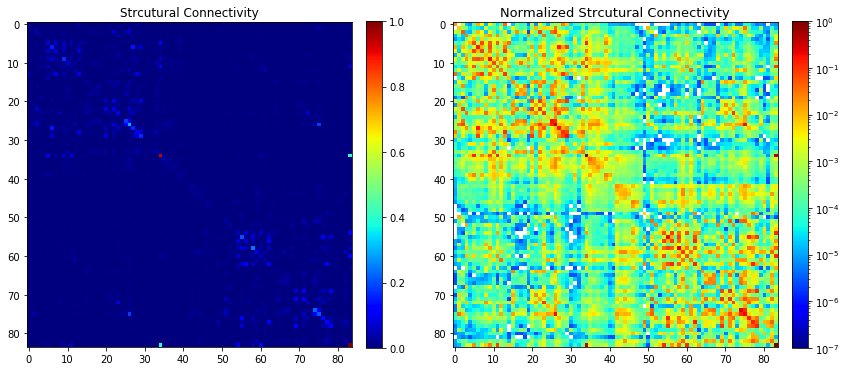

In [13]:
from matplotlib import colors, cm

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow((weights), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Strcutural Connectivity')

plt.subplot(122)
norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Normalized Strcutural Connectivity', fontsize=13.0)
plt.savefig(os.path.join(Res_dir,"Connectivity_CJ.png"))
#plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [14]:
iz_val=-3.7
pz_val=-2.1
ez_val=-1.5

ez_idx = np.array([6, 23],  dtype=np.int32)
pz_idx = np.array([9 , 22 ,26, 27, 34], dtype=np.int32)

In [15]:
SC=weights
SC.shape

(84, 84)

### Simulator

In [16]:
@jit(nopython=True) 
def VEP2Dmodel(params, constants, init_conditions, SC, dt, ts):
    
    nt=ts.shape[0]
    nn=SC.shape[0]
    
    #parameters
    eta=params[0:nn]
    K=params[-1]
    
    # fixed parameters
    tau0, I1, sigma=constants[0], constants[1], constants[2]


    # simulation from initial point
    x = np.zeros((nn, nt))  # fast voltage
    z = np.zeros((nn, nt))  # slow voltage

    # initial conditions
    x_init, z_init=init_conditions[0], init_conditions[1]
    for i in range(0, nn):
          x[i, 0] = x_init
          z[i, 0] = z_init
    

    # integrate ODE
    for t in range(0, nt-1):
        for i in range(0, nn):
            gx = 0;
            for j in range(0, nn):
                    gx = gx + SC[i, j]*(x[j, t] - x[i, t]);
            dx = 1.0 -  np.power(x[i, t], 3) - 2.0*np.power(x[i, t], 2) - z[i, t] + I1;
            dz = (1./tau0)*(4.*(x[i, t] - eta[i]) - z[i, t] - K*gx);
            x[i, t+1] = x[i, t] + dt*dx + np.sqrt(dt) * sigma * np.random.randn() 
            z[i, t+1] = z[i, t] + dt*dz + np.sqrt(dt) * sigma * np.random.randn()  
  
    
    return x.reshape(-1)  

### some simulations for  sanity check

In [17]:
T = 500.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [18]:
nt=ts.shape[0]
nt

5001

In [19]:
nn=SC.shape[0]
nn

84

In [20]:
tau0=300.
I1=3.1    
sigma=10e-2
constants = np.array([tau0, I1, sigma])

In [21]:
eta_true = np.ones(nn)*iz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [22]:
K_true=5.

In [23]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [24]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [25]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, SC, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.6783874034881592


In [26]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, SC, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.1251530647277832


In [27]:
X=Sim.reshape(nn, int(Sim.shape[0]/nn))
X.shape

(84, 5001)

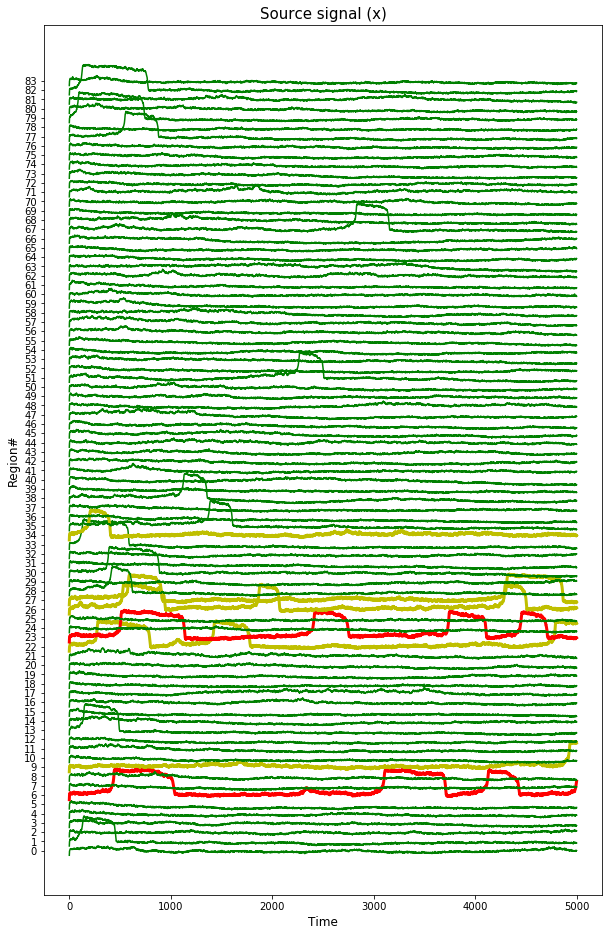

In [28]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X [i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.show()

## Euler, Heun and RK

In [52]:
@jit(nopython=True) 
def epileptor2D_fn(y, dt, sigma, eta, tau, K, SC):
    nn = SC.shape[0]
    x = y[0:nn]
    z = y[nn:2*nn]
    I1 = 3.1
    gx = sum(K * SC * (np.expand_dims(x, axis=0) - np.expand_dims(x, axis=1)), axis=1)
    dx = 1.0 - np.power(x, 3) - 2 * np.power(x, 2) - z + I1 + np.sqrt(dt)*sigma*np.random.randn()
    dz = (1.0/tau)*(4*(x - eta) - z - gx) + np.sqrt(dt)*sigma*np.random.randn(nn)
    return np.concatenate((dx, dz))

In [53]:
@jit(nopython=True) 
def Integrator_Euler(model_fn, nsteps, dt, sigma, y_init, eta, tau, K, SC):
    y_out = np.zeros((2*nn, nsteps))
    y_next = y_init
    h = dt
    for i in np.arange(nsteps):
            k1 = epileptor2D_fn(y_next, dt, sigma, eta, tau, K, SC)
            y_next = y_next + (h) * (k1)
            y_out[:,i] =  y_next 
    return y_out

In [54]:
@jit(nopython=True) 
def Integrator_Heun(model_fn, nsteps, dt, sigma, y_init, eta, tau, K, SC):
    y_out = np.zeros((2*nn, nsteps))
    y_next = y_init
    dh=1
    h = dt/dh
    for i in np.arange(nsteps):
            for j in np.arange(dh):
                k1 = epileptor2D_fn(y_next, dt, sigma, eta, tau, K, SC)
                k2 = epileptor2D_fn(y_next + h*k1, dt, sigma, eta, tau, K, SC)
                y_next = y_next + (h/2) * (k1 + k2)
            y_out[:,i] =  y_next 
    return y_out

In [55]:
@jit(nopython=True) 
def Integrator_RK23(model_fn, nsteps, dt, sigma, y_init, eta, tau, K, SC):
    y_out = np.zeros((2*nn, nsteps))
    y_next = y_init
    dh=6
    h = dt/dh
    for i in np.arange(nsteps):
        for j in np.arange(dh):
            k1 = epileptor2D_fn(y_next, dt, sigma, eta, tau, K, SC)
            k2 = epileptor2D_fn(y_next + h*(k1/2), dt, sigma, eta, tau, K, SC)
            y_next = y_next + (h) * (k2)
        y_out[:,i] =  y_next 
    return y_out

In [56]:
@jit(nopython=True) 
def Integrator_RK45(model_fn, nsteps, dt, sigma, y_init, eta, tau, K, SC):
    y_out = np.zeros((2*nn, nsteps))
    y_next = y_init
    dh=6
    h = dt/dh
    for i in np.arange(nsteps):
        for j in np.arange(dh):
            k1 = epileptor2D_fn(y_next, dt, sigma, eta, tau, K, SC)
            k2 = epileptor2D_fn(y_next + h*(k1/2), dt, sigma, eta, tau, K, SC)
            k3 = epileptor2D_fn(y_next + h*(k2/2), dt, sigma, eta, tau, K, SC)
            k4 = epileptor2D_fn(y_next + h*k3, dt, sigma, eta, tau, K, SC)
            y_next = y_next + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        y_out[:,i] =  y_next 
    return y_out

In [57]:
x_init_true = x_init *np.ones(nn)
z_init_true = z_init *np.ones(nn)
y_init_true =np.concatenate((x_init_true, z_init_true), axis=0)
y_init_true.shape

(168,)

In [58]:
sigma

0.1

# Run

In [59]:
start_time = time.time()
y_euler = Integrator_Euler(epileptor2D_fn(y_init_true, dt, sigma, eta_true, tau0, K_true, SC), nt, dt, sigma, y_init_true, eta_true, tau0, K_true, SC)
print(f"Simulation Euler took {time.time() - start_time} seconds")

Simulation Euler took 1.4513952732086182 seconds


In [60]:
start_time = time.time()
y_euler = Integrator_Euler(epileptor2D_fn(y_init_true, dt, sigma, eta_true, tau0, K_true, SC), nt, dt, sigma, y_init_true, eta_true, tau0, K_true, SC)
print(f"Simulation Euler took {time.time() - start_time} seconds")

Simulation Euler took 0.13052654266357422 seconds


In [61]:
start_time = time.time()
y_heun = Integrator_Heun(epileptor2D_fn(y_init_true, dt, sigma, eta_true, tau0, K_true, SC), nt, dt, sigma, y_init_true, eta_true, tau0, K_true, SC)
print(f"Simulation Heun took {time.time() - start_time} seconds")

Simulation Heun took 1.0834734439849854 seconds


In [62]:
start_time = time.time()
y_heun = Integrator_Heun(epileptor2D_fn(y_init_true, dt, sigma, eta_true, tau0, K_true, SC), nt, dt, sigma, y_init_true, eta_true, tau0, K_true, SC)
print(f"Simulation Heun with numba took {time.time() - start_time} seconds")

Simulation Heun with numba took 0.2487499713897705 seconds


In [63]:
start_time = time.time()
y_rk23 = Integrator_RK23(epileptor2D_fn(y_init_true, dt, sigma, eta_true, tau0, K_true, SC), nt, dt, sigma, y_init_true, eta_true, tau0, K_true, SC)
print(f"Simulation RK23 took {time.time() - start_time} seconds")

Simulation RK23 took 2.1745734214782715 seconds


In [64]:
start_time = time.time()
y_rk23 = Integrator_RK23(epileptor2D_fn(y_init_true, dt, sigma, eta_true, tau0, K_true, SC), nt, dt, sigma, y_init_true, eta_true, tau0, K_true, SC)
print(f"Simulation RK23 with numba took {time.time() - start_time} seconds")

Simulation RK23 with numba took 1.4493486881256104 seconds


In [65]:
start_time = time.time()
y_rk45 = Integrator_RK45(epileptor2D_fn(y_init_true, dt, sigma, eta_true, tau0, K_true, SC), nt, dt, sigma, y_init_true, eta_true, tau0, K_true, SC)
print(f"Simulation RK45 took {time.time() - start_time} seconds")

Simulation RK45 took 3.744859457015991 seconds


In [66]:
start_time = time.time()
y_rk45 = Integrator_RK45(epileptor2D_fn(y_init_true, dt, sigma, eta_true, tau0, K_true, SC), nt, dt, sigma, y_init_true, eta_true, tau0, K_true, SC)
print(f"Simulation RK45 with numba took {time.time() - start_time} seconds")

Simulation RK45 with numba took 2.894585609436035 seconds


In [67]:
y_euler.shape

(168, 5001)

In [68]:
X_euler=y_euler[0:nn,:]
X_heun=y_heun[0:nn,:]
X_rk23=y_rk23[0:nn,:]
X_rk45=y_rk45[0:nn,:]

X_euler.shape

(84, 5001)

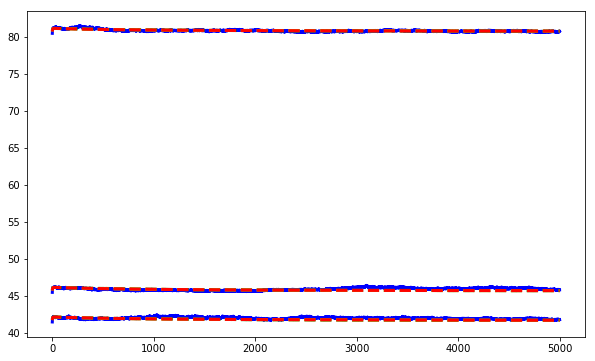

In [69]:
plt.figure(figsize=(10,6))
for i in range(0, nn):
    if i in [44, 48, 83]:
          plt.plot(X[i,:]+i, 'b', lw=3)
          plt.plot(X_euler[i,:]+i, 'g--', lw=3)
          plt.plot(X_heun[i,:]+i, 'y--', lw=3)
          plt.plot(X_rk45[i,:]+i, 'r--', lw=3)

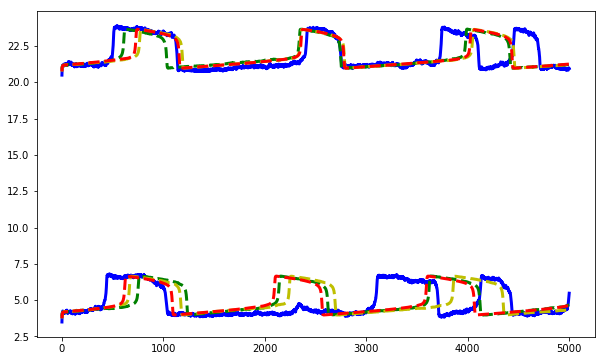

In [70]:
plt.figure(figsize=(10,6))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'b', lw=3)
          plt.plot(X_euler[i,:]+i, 'g--', lw=3)
          plt.plot(X_heun[i,:]+i, 'y--', lw=3)
          plt.plot(X_rk45[i,:]+i, 'r--', lw=3)

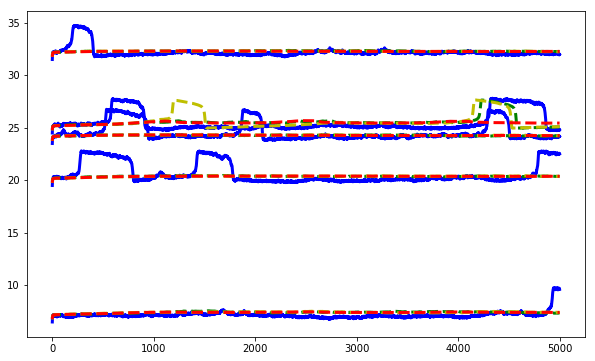

In [71]:
plt.figure(figsize=(10,6))
for i in range(0, nn):
    if i in pz_idx:
          plt.plot(X[i,:]+i, 'b', lw=3)
          plt.plot(X_euler[i,:]+i, 'g--', lw=3)
          plt.plot(X_heun[i,:]+i, 'y--', lw=3)
          plt.plot(X_rk45[i,:]+i, 'r--', lw=3)

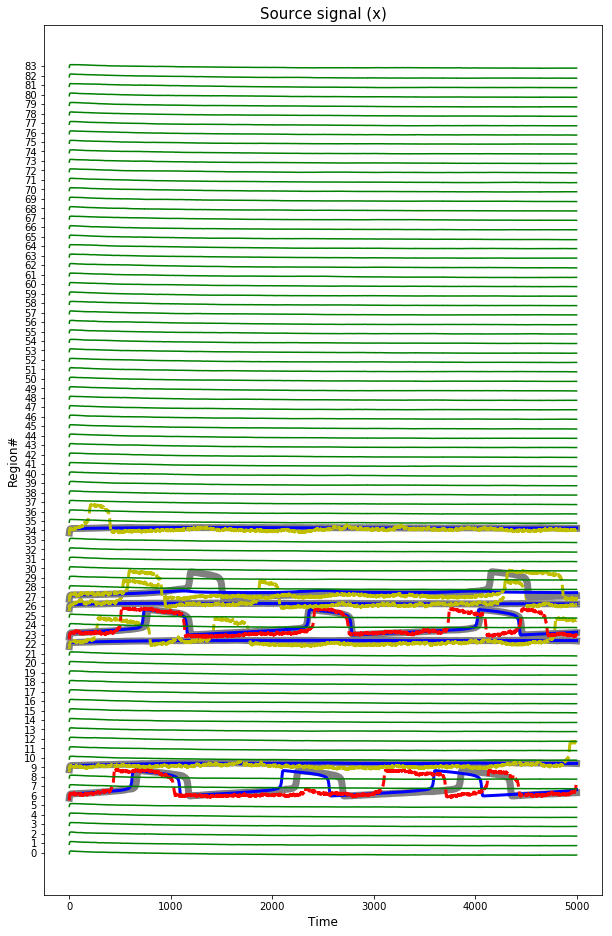

In [72]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X_heun[i,:]+i, 'grey', lw=7)
          plt.plot(X_rk45[i,:]+i, 'b', lw=3)
          plt.plot(X[i,:]+i, '--r', lw=3)
    elif i in pz_idx:
          plt.plot(X_heun[i,:]+i, 'grey', lw=7)
          plt.plot(X_rk45[i,:]+i, 'b', lw=3)
          plt.plot(X[i,:]+i, '--y', lw=3)
    else:  
          plt.plot(X_euler[i,:]+i, 'g')
            
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.show()